This file is to clearn the TUH EEG seizure data

1. Create a csv file to contains all edf and the labels

2. A class to load data


In [3]:
import sys
sys.path.append("../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT

In [4]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from easydict import EasyDict as edict
import torch
import mne

%matplotlib inline
plt.style.use(FIG_ROOT/"base.mplstyle")

In [5]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [6]:
from data_utils.eeg_load import EEGData
from data_utils.sz_utils import txt2labinfo, sz_lab_from_row_fn
from data_utils.utils import get_triple, convert_to_type, rec_data, digitize_data
from utils.misc import load_txt, save_pkl, load_pkl

In [7]:
root = list(DATA_ROOT.glob("EEG_seizure"))[0]
root

PosixPath('/data/rajlab1/user_data/jin/MyResearch/EEG-sz-det_dev/notebooks/../mypkg/../data/EEG_seizure')

# Pre-analysis

# Output csv file

Csv file lists all files

In [ ]:
names =["dataset", "sub", 
        "session", "montage", 
        "file_stem", 
        "relative_path", "is_seizure", "total_dur", 
        "lab", "all_chs"]
working_set = "eval" # train, eval, dev 
working_path = root/("edf/"+working_set)

In [ ]:
def path2info(p):
    p_dir = "/".join(str(p).split("/")[-5:]).split('.')[0]
    txt = load_txt(p.with_suffix(".csv_bi"))
    infos = txt2labinfo(txt)
    return str(p.parent).split("/")[-4:] \
            + [p.stem]  \
            + [p_dir]  \
            + [infos["is_seizure"]] \
            + [infos["total_dur"]] \
            + [infos["labs"]]

In [ ]:
all_infos = []
for p in tqdm(working_path.rglob("*.edf")):
    base_info = path2info(p)
    dat = mne.io.read_raw_edf(p, verbose=False)
    ch_names_simple = [ch_name.split(" ")[-1].split("-")[0].strip() for ch_name in dat.ch_names];
    all_info = base_info + [';'.join(ch_names_simple)]
    all_infos.append(all_info)

In [ ]:
df = pd.DataFrame(all_infos, columns=names)
df.to_csv(root/f"all_data_{working_set}.csv");

In [ ]:
df = pd.read_csv(root/f"all_data_{working_set}.csv");

In [ ]:
import ast
def _tmp_fn(x):
    v = [vs[1] - vs[0] for 
         vs in ast.literal_eval(x) 
         if vs[2] == "seiz"]
    return v
    
df["lab"].map(_tmp_fn)

In [ ]:
tmp = df['lab'].iloc[0]

# Load and split data

In [ ]:
all_train = pd.read_csv(root/f"all_data_train.csv", index_col=0);

In [ ]:
def split_vec(vec, ratio=0.9):
    vec = np.array(vec)
    true_indices = np.where(vec)[0]
    false_indices = np.where(~vec)[0]

    np.random.shuffle(true_indices)
    np.random.shuffle(false_indices)

    true_count = len(true_indices)
    false_count = len(false_indices)

    true_split = int(true_count * ratio)
    false_split = int(false_count * ratio)

    vec1_indices = np.concatenate((true_indices[:true_split], false_indices[:false_split]))
    vec2_indices = np.concatenate((true_indices[true_split:], false_indices[false_split:]))

    return np.sort(vec1_indices), np.sort(vec2_indices)
seizure_idxs = all_train["is_seizure"]
set1_idxs, set2_idxs = split_vec(seizure_idxs)

In [ ]:
set1 = all_train.copy().iloc[set1_idxs]
set2 = all_train.copy().iloc[set2_idxs]
set1 = set1.reset_index(drop=True)
set2 = set2.reset_index(drop=True);
set1.to_csv(root/f"all_data_train_train.csv")
set2.to_csv(root/f"all_data_train_test.csv")

In [ ]:
# output data without seizure. 
train_train_data = pd.read_csv(root/f"all_data_train_train.csv", index_col=0)
train_test_data = pd.read_csv(root/f"all_data_train_test.csv", index_col=0);

In [ ]:
train_test_health = train_test_data[train_test_data["is_seizure"] == False];
train_test_health = train_test_health.reset_index(drop=True)
train_train_health = train_train_data[train_train_data["is_seizure"] == False];
train_train_health = train_train_health.reset_index(drop=True)

train_test_health.to_csv(root/"all_data_train_test_health.csv")
train_train_health.to_csv(root/"all_data_train_train_health.csv")

In [ ]:
# A small training set
train_train_data_health = pd.read_csv(root/f"all_data_train_train_health.csv", index_col=0);
total_num = len(train_train_data_health)
sel_idxs = np.sort(np.random.choice(total_num, size=int(0.1*total_num), replace=False));
train_train_data_health_small = train_train_data_health.iloc[sel_idxs].reset_index(drop=True);
train_train_data_health_small.to_csv(root/"all_data_train_train_health_small.csv")

# Process data and save it

In [ ]:
dataset = EEGData("eval", "ALL", 
                   pre_params=dict(is_detrend=True, 
                              is_drop=True,
                              target_fs=90, 
                              filter_limit=[1, 45], 
                              is_diff=False)
                  );

In [ ]:
from tqdm import trange
for ix in trange(len(dataset.all_data)):
    dataset.get_preprocess_data(ix, regen=False)

# Test Data discretization

In [32]:
from data_utils.eeg_load_sz import EEGDataSZ
from data_utils.eeg_load import EEGData
from data_utils.utils import rec_data, digitize_data

In [66]:
dataset = EEGDataSZ("eval", "AR",
                  verbose=2,
                  label="sz",
                  discrete_k = None,
                   pre_params=dict(is_detrend=True, 
                              is_drop=True,
                              target_fs=90, 
                              filter_limit=[1, 45], 
                              is_diff=False)
                  );

In [67]:
data  = dataset[2]
data_dis = dataset._get_dis_data(data, k=8)
data_rec = dataset._rec_dis_data(data_dis, k=8);

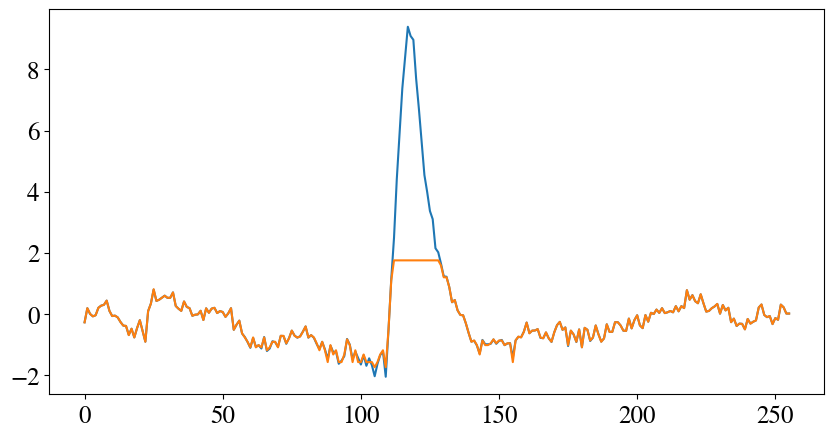

In [68]:
seq_ix = 0
plt.plot(data[:, seq_ix])
plt.plot(data_rec[:, seq_ix])

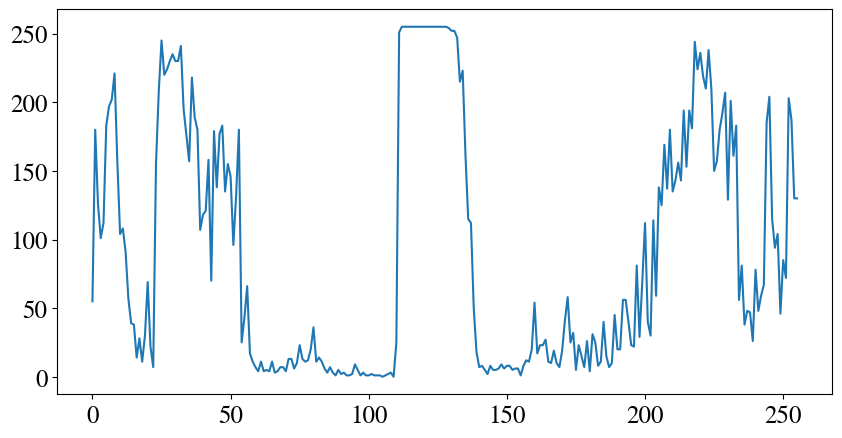

In [69]:
seq_ix = 0
plt.plot(data_dis[:, seq_ix])

code is update above. 
Below is the old code date: 2024-06-23


# Remove saved `pkl` file

In [ ]:
working_set = "train" # train, eval and dev
all_data = pd.read_csv(root/f"all_data_{working_set}.csv", index_col=0);
pbar = trange(len(all_data))
nfil = 0
for ix in pbar:
    dat_path = (root/"edf"/all_data["relative_path"].iloc[ix])
    # change the data name
    pkl_fs = list(dat_path.parent.glob("*.pkl"))
    pbar.set_postfix({'n_removed_file': nfil}, refresh=True)
    for pkl_f in pkl_fs:
        if not pkl_f.stem.endswith("90"):
            pass
            print(pkl_f)
        nfil += 1
        pbar.set_postfix({'n_removed_file': nfil}, refresh=True)
        #pkl_f.unlink()

# Check the edf data

In [ ]:
working_set = "train"
all_data = pd.read_csv(root/f"all_data_{working_set}.csv", index_col=0);
dat_path = (root/"edf"/all_data["relative_path"].iloc[0]).with_suffix(".edf")
dat = mne.io.read_raw_edf(dat_path, verbose=False, preload=True);
dat.filter(l_freq=1, h_freq=45, verbose=False)
dat.resample(90)

In [ ]:
data = dat.get_data();
duration = 100
start = 2000
plt.plot(data[5, start:start+duration])

# Parse seizure onset time info

Test `seiz_lab_fn` and `seiz_lab_from_row_fn` 

In [ ]:
all_data = pd.read_csv(root/f"all_data_train.csv", index_col=0);

In [ ]:
all_data.head()

In [ ]:
seiz_lab_from_row_fn(all_data[all_data["is_seizure"]].iloc[5])
#seiz_lab_from_row_fn(all_data.iloc[4])